In [1]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tomli
from syscaps.models import model_factory
from syscaps.data.energyplus import EnergyPlusDataset
from syscaps.data.wind import WindDataset
from syscaps import utils
from transformers import BertTokenizer, DistilBertTokenizer
import torch 
import textwrap 


sns.set_style("whitegrid")
pd.set_option('display.max_rows', 500)
# set font size seaborn
sns.set_context("notebook", font_scale=1.25)

%load_ext autoreload
%autoreload 2
%matplotlib inline 

/projects/cascde/.conda_envs/syscaps/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set the `SYSCAPS` environment variable to the path where the datasets are stored under. The data should be stored under a directory called `BuildingsBench`. Many of the Python scripts in this project use the `SYSCAPS` environment variable to locate data and metadata.

In [2]:
os.environ['SYSCAPS'] = '/projects/cascde/pemami/v2.0.0/BuildingsBench/'
# set Huggingface cache
os.environ["HF_HOME"] = "/projects/cascde/.cache"
os.environ["HF_HUB_CACHE"] = "/projects/cascde/.cache"
CACHE = os.environ.get('HF_HUB_CACHE', '')

In [3]:
# The dataset directory 
SYSCAPS_PATH = os.environ.get('SYSCAPS', '')
if SYSCAPS_PATH == '':
    raise ValueError('SYSCAPS environment variable not set')
SYSCAPS_PATH = Path(SYSCAPS_PATH)

The attributes used to create these captions are stored in parquet files under the `Buildings-900K` dataset sub-directory: 

In [7]:
buildings_bench_path = SYSCAPS_PATH / 'Buildings-900K' / 'end-use-load-profiles-for-us-building-stock' / '2021'
df1 = pd.read_parquet(buildings_bench_path / 'comstock_amy2018_release_1' / 'metadata' / 'metadata.parquet', engine="pyarrow")
df2 = pd.read_parquet(buildings_bench_path / 'comstock_tmy3_release_1' / 'metadata' / 'metadata.parquet', engine="pyarrow")
df = df1.loc[ df1.index.intersection(df2.index).values ]
df.index

Index([   105,    170,    254,    313,    318,    425,    522,    601,    625,
          858,
       ...
       343340, 344535, 344876, 345132, 345431, 347436, 348460, 348844, 349399,
       349740],
      dtype='int64', name='bldg_id', length=345571)

In [8]:
df1

applicability in.upgrade_name  in.tstat_clg_delta_f  \
bldg_id                                                        
105               True        Baseline                   5.0   
170               True        Baseline                   5.0   
254               True        Baseline                   6.0   
313               True        Baseline                   0.0   
318               True        Baseline                   0.0   
...                ...             ...                   ...   
347436            True        Baseline                  10.0   
348460            True        Baseline                  10.0   
348844            True        Baseline                   8.0   
349399            True        Baseline                   4.0   
349740            True        Baseline                   6.0   

         in.tstat_clg_sp_f  in.tstat_htg_delta_f  in.tstat_htg_sp_f  \
bldg_id                                                               
105                   77.0                   8.0               63.0   
170                   74.0                   5.0               69.0   
254                   71.0                   8.0               68.0   
313                   72.0                  10.0               68.0   
318                   75.0                   8.0               66.0   
...                    ...                   ...                ...   
347436                71.0                   8.0               68.0   
348460                72.0                   6.0               68.0   
348844                74.0                   7.0               68.0   
349399                76.0                   3.0               66.0   
349740               999.0                  10.0              999.0   

         in.aspect_ratio      in.building_subtype in.county  \
bldg_id                                                       
105                  2.0                     None  G0100890   
170                  3.0                     None  G0100690   
254                  2.0  strip_mall_restaurant20  G0100950   
313                  2.0  strip_mall_restaurant20  G0100490   
318                  4.0                     None  G0101170   
...                  ...                      ...       ...   
347436               2.0                     None  G5600210   
348460               1.0                     None  G5600130   
348844               1.0                     None  G5600390   
349399               2.0                     None  G5600210   
349740               2.0                     None  G5600330   

              in.building_type  ...  \
bldg_id                         ...   
105                SmallOffice  ...   
170                SmallOffice  ...   
254            RetailStripmall  ...   
313            RetailStripmall  ...   
318                SmallOffice  ...   
...                        ...  ...   
347436           PrimarySchool  ...   
348460        RetailStandalone  ...   
348844   FullServiceRestaurant  ...   
349399             SmallOffice  ...   
349740               Warehouse  ...   

         out.electricity.total.energy_consumption_intensity  \
bldg_id                                                       
105                                               9.081111    
170                                              10.201852    
254                                              29.444074    
313                                              23.236815    
318                                              16.733333    
...                                                    ...    
347436                                            7.885259    
348460                                            9.938370    
348844                                           92.690741    
349399                                           11.100741    
349740                                            8.498095    

         out.site_energy.total.energy_consumption  \
bldg_id                                            

In [9]:
# the attribute parquet files are indexed by building id
df.loc[100000].to_dict()

{'applicability': True,
 'in.upgrade_name': 'Baseline',
 'in.tstat_clg_delta_f': 0.0,
 'in.tstat_clg_sp_f': 999.0,
 'in.tstat_htg_delta_f': 7.0,
 'in.tstat_htg_sp_f': 999.0,
 'in.aspect_ratio': 4.0,
 'in.building_subtype': None,
 'in.county': 'G2101110',
 'in.building_type': 'Warehouse',
 'in.rotation': 0.0,
 'in.number_of_stories': 1.0,
 'in.sqft': 350000.0,
 'in.hvac_system_type': 'Gas unit heaters',
 'in.weekday_operating_hours': 18.75,
 'in.weekday_opening_time': 4.0,
 'in.weekend_operating_hours': 12.0,
 'in.weekend_opening_time': 9.25,
 'in.energy_code_followed_during_last_exterior_lighting_replaceme': 'ComStock 90.1-2007',
 'in.energy_code_followed_during_last_hvac_replacement': 'ComStock 90.1-2010',
 'in.energy_code_followed_during_last_interior_equipment_replacem': 'ComStock 90.1-2010',
 'in.energy_code_followed_during_last_interior_lighting_replaceme': 'ComStock 90.1-2019',
 'in.energy_code_followed_during_last_roof_replacement': 'ComStock DOE Ref 1980-2004',
 'in.energy_code

We only use a subset of these attributes. The filtered list of attribute names for commercial buildings used in our work is stored in a file called `attributes_comstock.txt`.

In [10]:
attributes = open(SYSCAPS_PATH / 'metadata' / 'syscaps' / 'energyplus' / 'attributes_comstock.txt', 'r').read().strip().split('\n')
# remove empty strings and quotations
attributes = [x.strip('"') for x in attributes]
list(filter(None, attributes))

['in.building_subtype',
 'in.building_type',
 'in.number_of_stories',
 'in.sqft',
 'in.hvac_system_type',
 'in.weekday_operating_hours',
 'in.weekday_opening_time',
 'in.weekend_operating_hours',
 'in.weekend_opening_time',
 'in.tstat_clg_delta_f',
 'in.tstat_clg_sp_f',
 'in.tstat_htg_delta_f',
 'in.tstat_htg_sp_f']

We can repeat this to explore the Wind dataset. 

In [11]:
!ls -l $SYSCAPS/captions/wind/medium/aug_0 | head -n 5

total 2240
-rw-rw-r-- 1 pemami foundation 244611 Oct 15 21:17 captions.csv
-rw-rwxr-- 1 pemami foundation    357 Feb 19  2024 Layout000_cap.txt
-rw-rwxr-- 1 pemami foundation    372 Feb 19  2024 Layout001_cap.txt
-rw-rwxr-- 1 pemami foundation    548 Feb 19  2024 Layout002_cap.txt
ls: write error: Broken pipe


In [12]:
# `captions` is the name of the subdirectory containing the captions
# `wind` is the name of the Wind dataset (FLORIS is the simulator name)
#  `medium` is the caption length
#  `aug_0` is the style augmentation type
for idx in range(4):
    with open(SYSCAPS_PATH /  'captions' / 'wind' / 'medium' / 'aug_0' / f'Layout{idx:03}_cap.txt') as f:
        print( f.read() )
        print()

 Nestled within a picturesque landscape, this wind plant boasts a cluster layout, housing a total of 101 turbines that stand tall at an impressive 130 meters in diameter. With a deliberate spacing of five times the rotor diameter, the turbines are strategically positioned to maximize energy production, resulting in a combined rated power of 3.4 megawatts.

 This wind plant features a single-string configuration with 30 turbines, each boasting a rotor diameter of 130 meters. The turbines are spaced at an average distance of four times the rotor diameter, resulting in a highly efficient energy capture. Each turbine is capable of generating 3.4 megawatts of power, making it a significant contributor to the local energy grid.

 Sure, here's a description of the wind plant based on the provided attributes:
Located in a vast, open area, this wind plant is arranged in a cluster formation, with 188 turbines standing tall and proud, each with a rotor diameter of 130 meters. The turbines are spa

## Qualitative examples

- short, medium, long captions
- wind

In [35]:
model_config = Path('../syscaps') / 'configs' / 'energyplus_comstock' / 'medium' / 'SSM_bert.toml'
# grab the custom model args as set in the config file
toml_args = tomli.load((model_config).open('rb'))
# create the model
model = model_factory(toml_args['experiment']['module_name'], 'energyplus_comstock', toml_args['model'])
# load the model weights from HF
#model.from_pretrained('NREL/building-surrogate-nl', use_safetensors=True)
model.load_from_checkpoint('/projects/cascde/pemami/resstock-comstock-surrogates/checkpoints/pemami/SSM_bert_energyplus_comstock_medium_seed=1000_merged_renamed.pt')
model = model.to('cuda')
# set the model to eval mode
model.eval()
# load the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model_kv_config = Path('../syscaps') / 'configs' / 'energyplus_comstock' / 'keyvalue' / 'SSM_bert.toml'
# grab the custom model args as set in the config file
toml_args = tomli.load((model_config).open('rb'))
# create the model
model_kv = model_factory(toml_args['experiment']['module_name'], 'energyplus_comstock', toml_args['model'])
# load the model weights from HF
#model.from_pretrained('NREL/building-surrogate-nl', use_safetensors=True)
model_kv.load_from_checkpoint('/projects/cascde/pemami/resstock-comstock-surrogates/checkpoints/pemami/SSM_bert_energyplus_comstock_keyvalue_seed=1000_merged_renamed.pt')
model_kv = model_kv.to('cuda')
# set the model to eval mode
model_kv.eval()

/projects/cascde/.conda_envs/syscaps/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


EnergyPlusSequential(
  (attr_encoder): TextEncoder(
    (model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768,

In [36]:
medium_dataset = EnergyPlusDataset(
    data_path=SYSCAPS_PATH,
    index_file='comstock_attribute_combos_seed=42.idx',
    resstock_comstock='comstock',
    syscaps_split='medium',
    return_full_year=True,
    include_text = True
)

denorm = medium_dataset.load_transform.undo_transform

keyvalue_dataset = EnergyPlusDataset(
    data_path=SYSCAPS_PATH,
    index_file='comstock_attribute_combos_seed=42.idx',
    resstock_comstock='comstock',
    syscaps_split='keyvalue',
    return_full_year=True,
    include_text = True
)
short_dataset = EnergyPlusDataset(
    data_path=SYSCAPS_PATH,
    index_file='comstock_attribute_combos_seed=42.idx',
    resstock_comstock='comstock',
    syscaps_split='short',
    return_full_year=True,
    include_text = True
)

long_dataset = EnergyPlusDataset(
    data_path=SYSCAPS_PATH,
    index_file='comstock_attribute_combos_seed=42.idx',
    resstock_comstock='comstock',
    syscaps_split='long',
    return_full_year=True,
    include_text = True
)
datasets = {
    'medium': medium_dataset,
    'short': short_dataset,
    'long': long_dataset,
    'keyvalue': keyvalue_dataset
}
indices = [1, 10, 20, 30, 50]
# dataloaders = {
#     'medium': torch.utils.data.DataL
# }


/projects/cascde/.conda_envs/syscaps/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[EnergyPlusDataset] Captions with more than 512 tokens will be truncated!
[EnergyPlusDataset] # attributes 13, attributes onehot shape = (1, 336)


/projects/cascde/.conda_envs/syscaps/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[EnergyPlusDataset] Captions with more than 512 tokens will be truncated!
[EnergyPlusDataset] # attributes 13, attributes onehot shape = (1, 336)


/projects/cascde/.conda_envs/syscaps/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[EnergyPlusDataset] Captions with more than 512 tokens will be truncated!
[EnergyPlusDataset] # attributes 13, attributes onehot shape = (1, 336)


/projects/cascde/.conda_envs/syscaps/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[EnergyPlusDataset] Captions with more than 512 tokens will be truncated!
[EnergyPlusDataset] # attributes 13, attributes onehot shape = (1, 336)


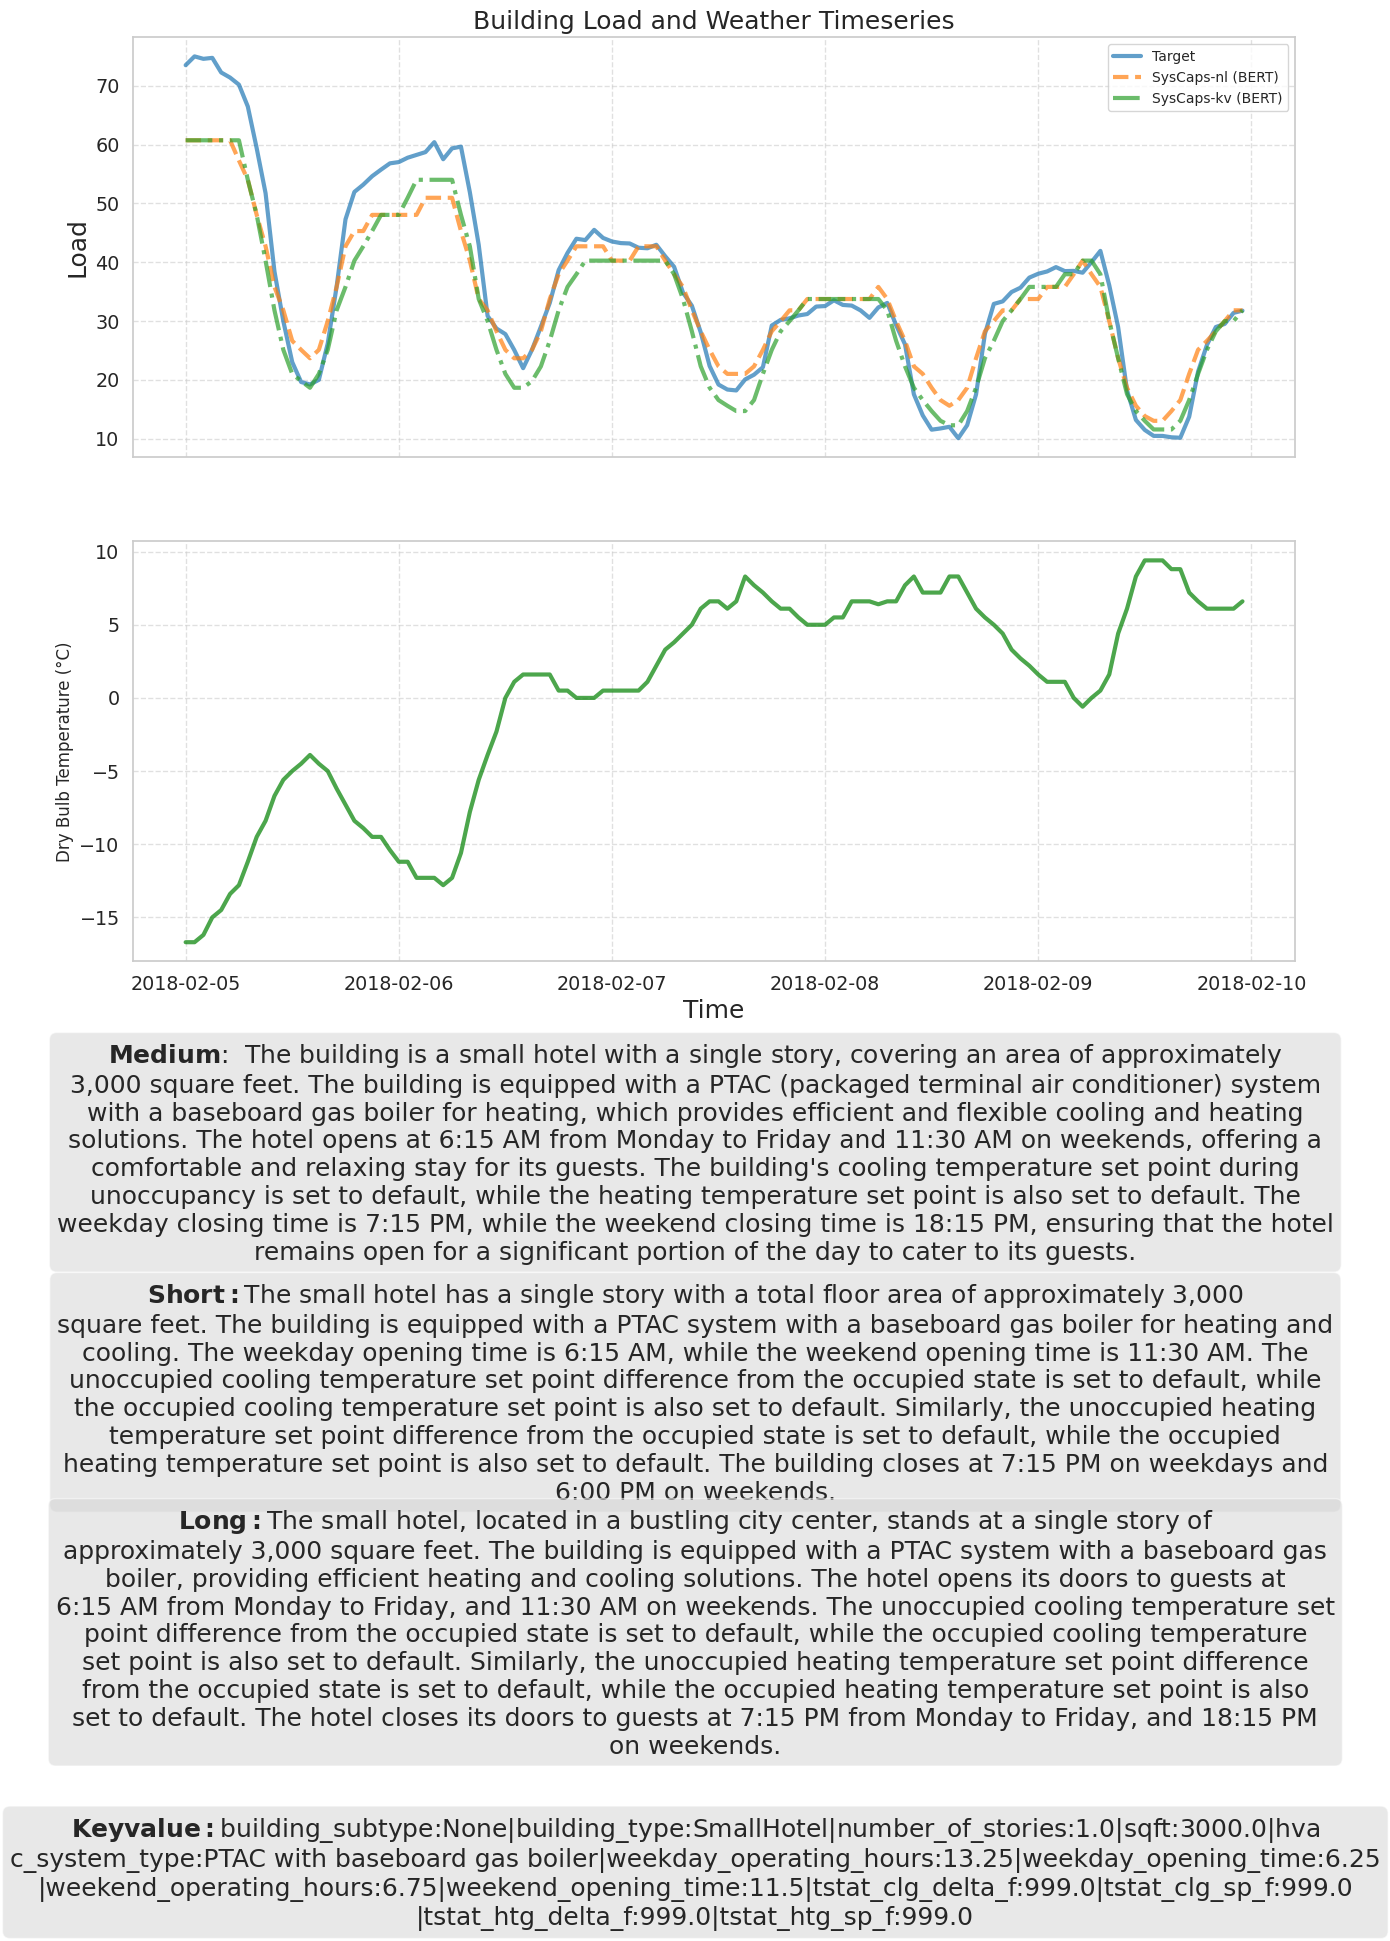

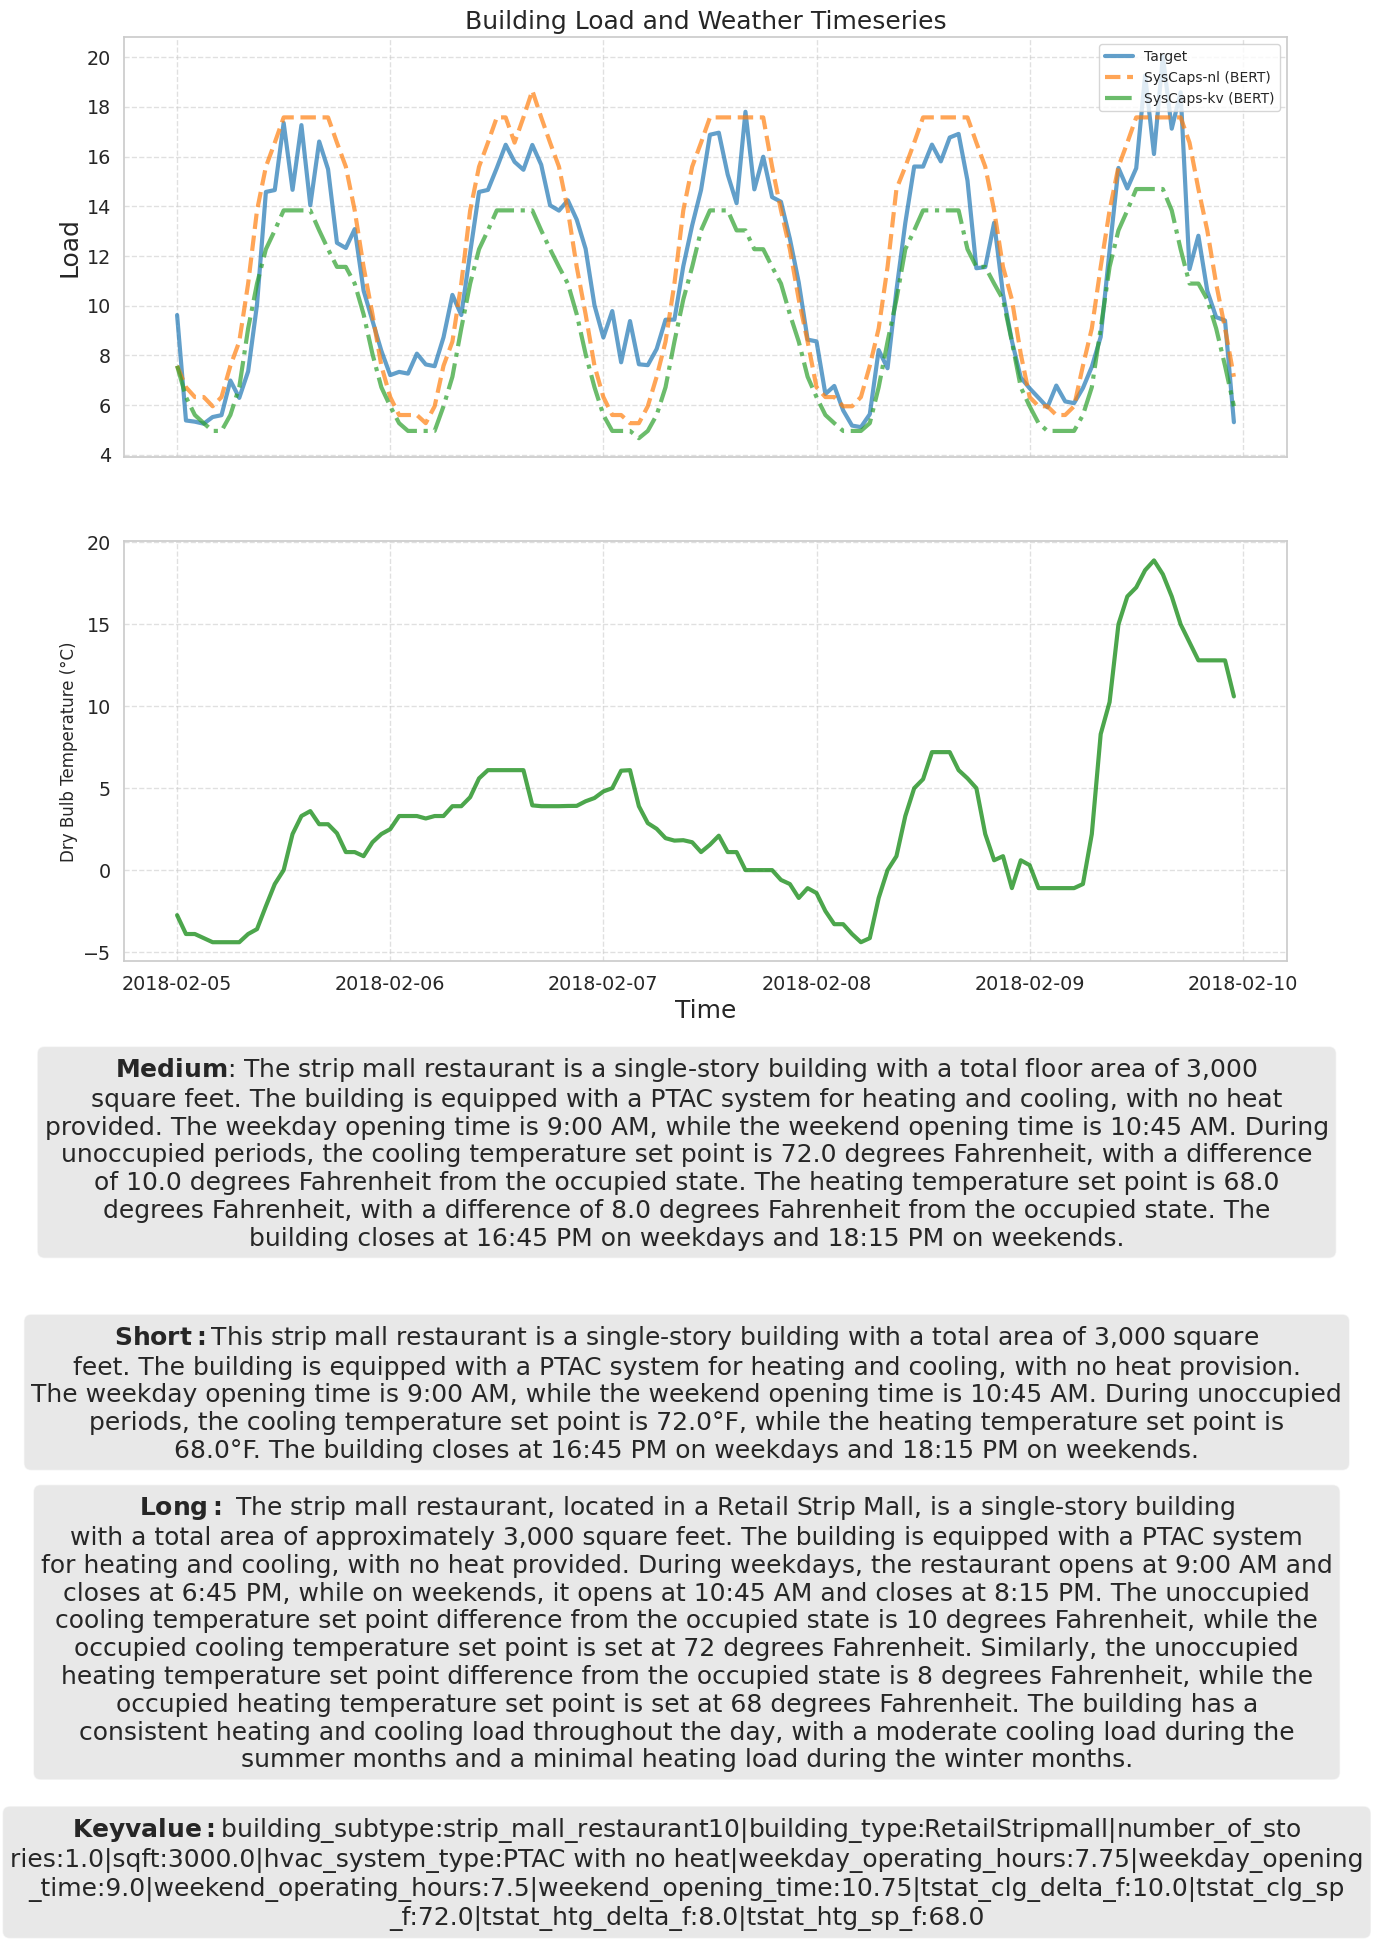

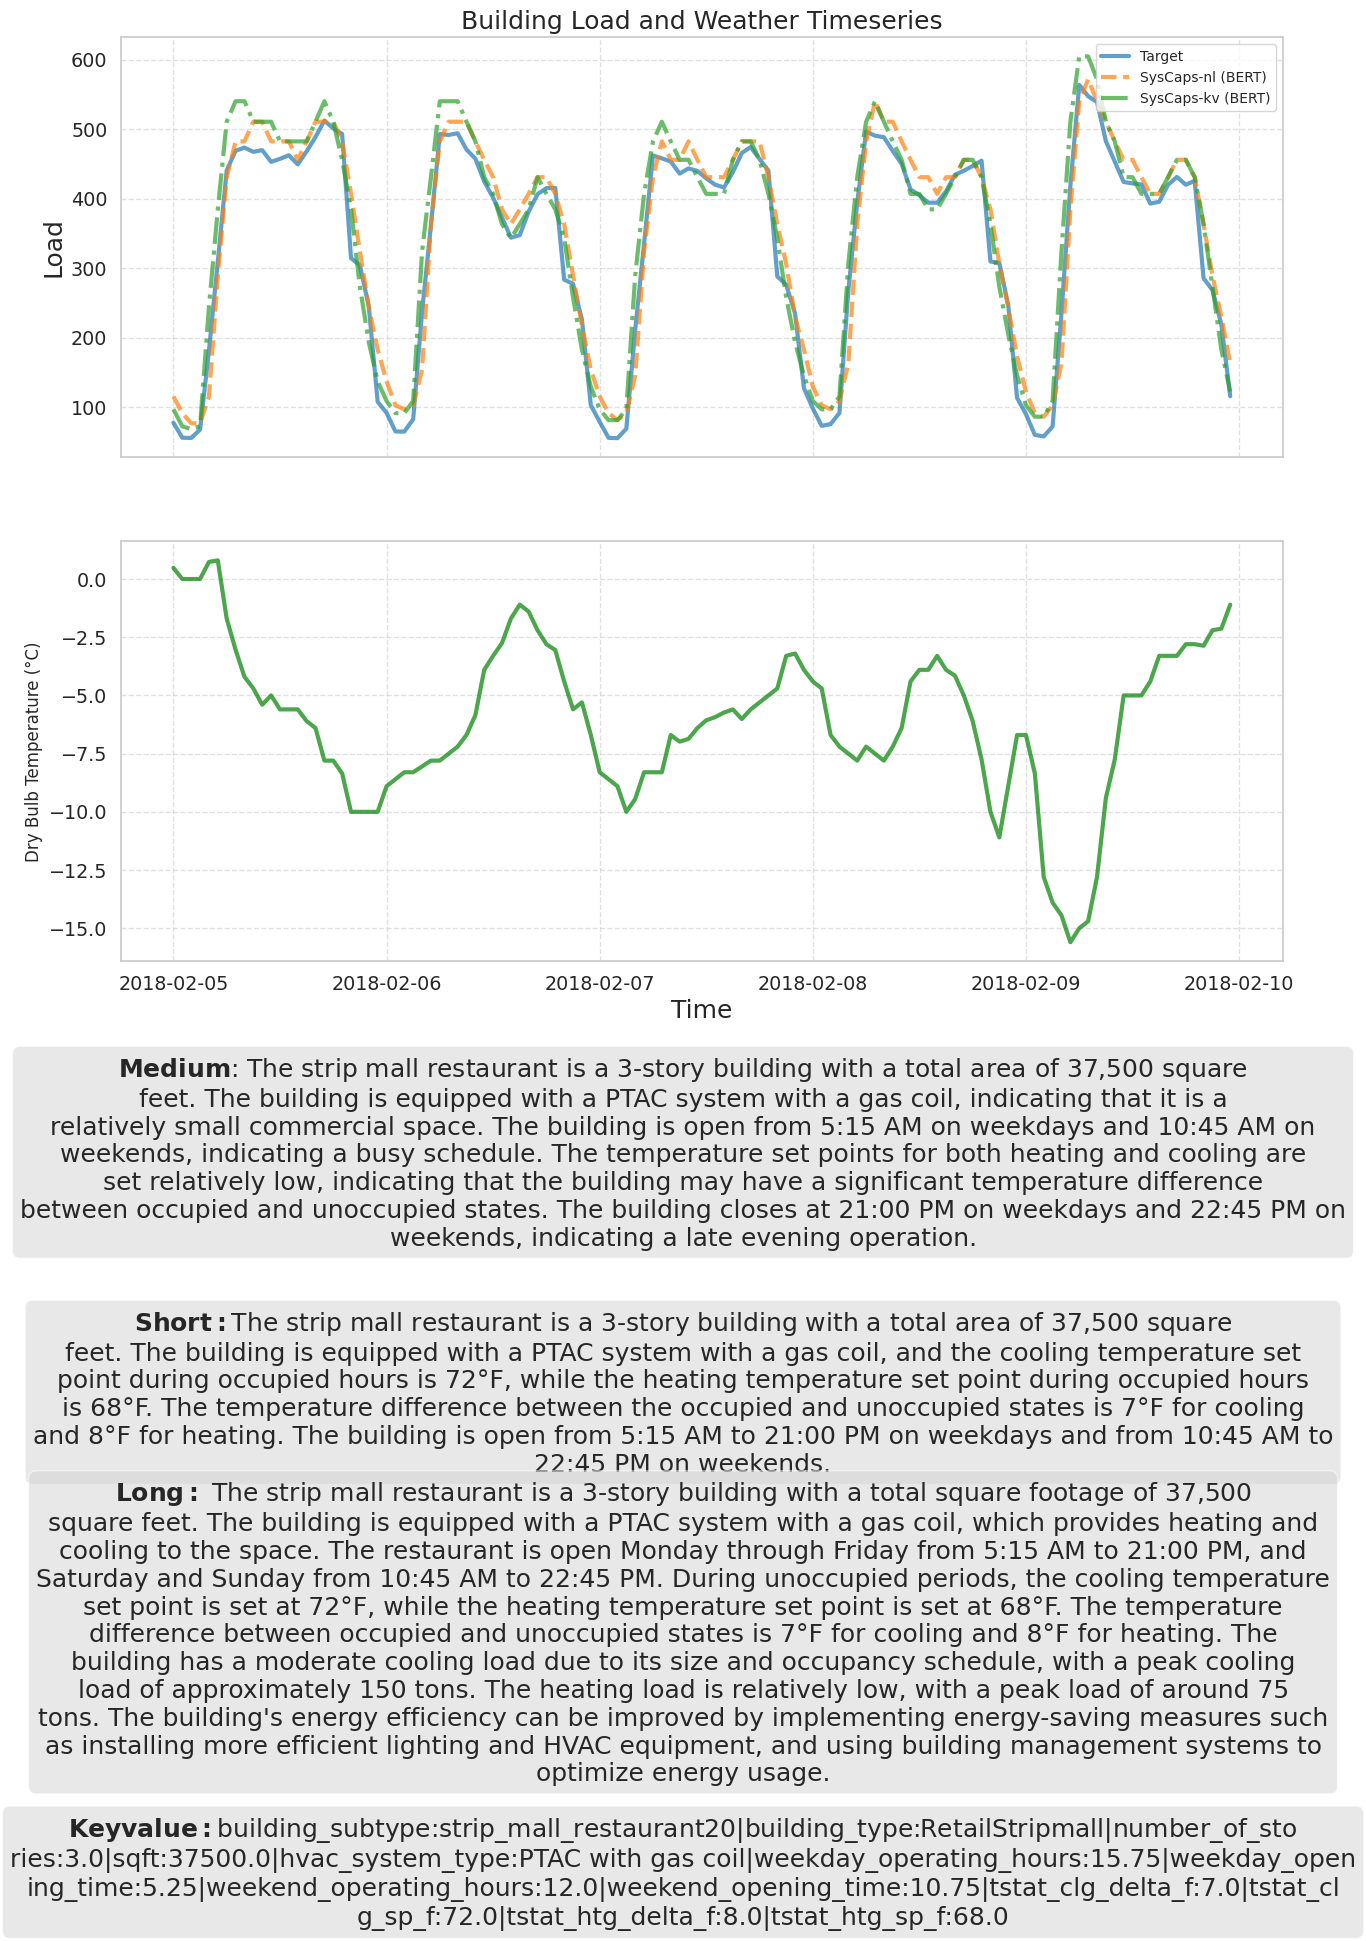

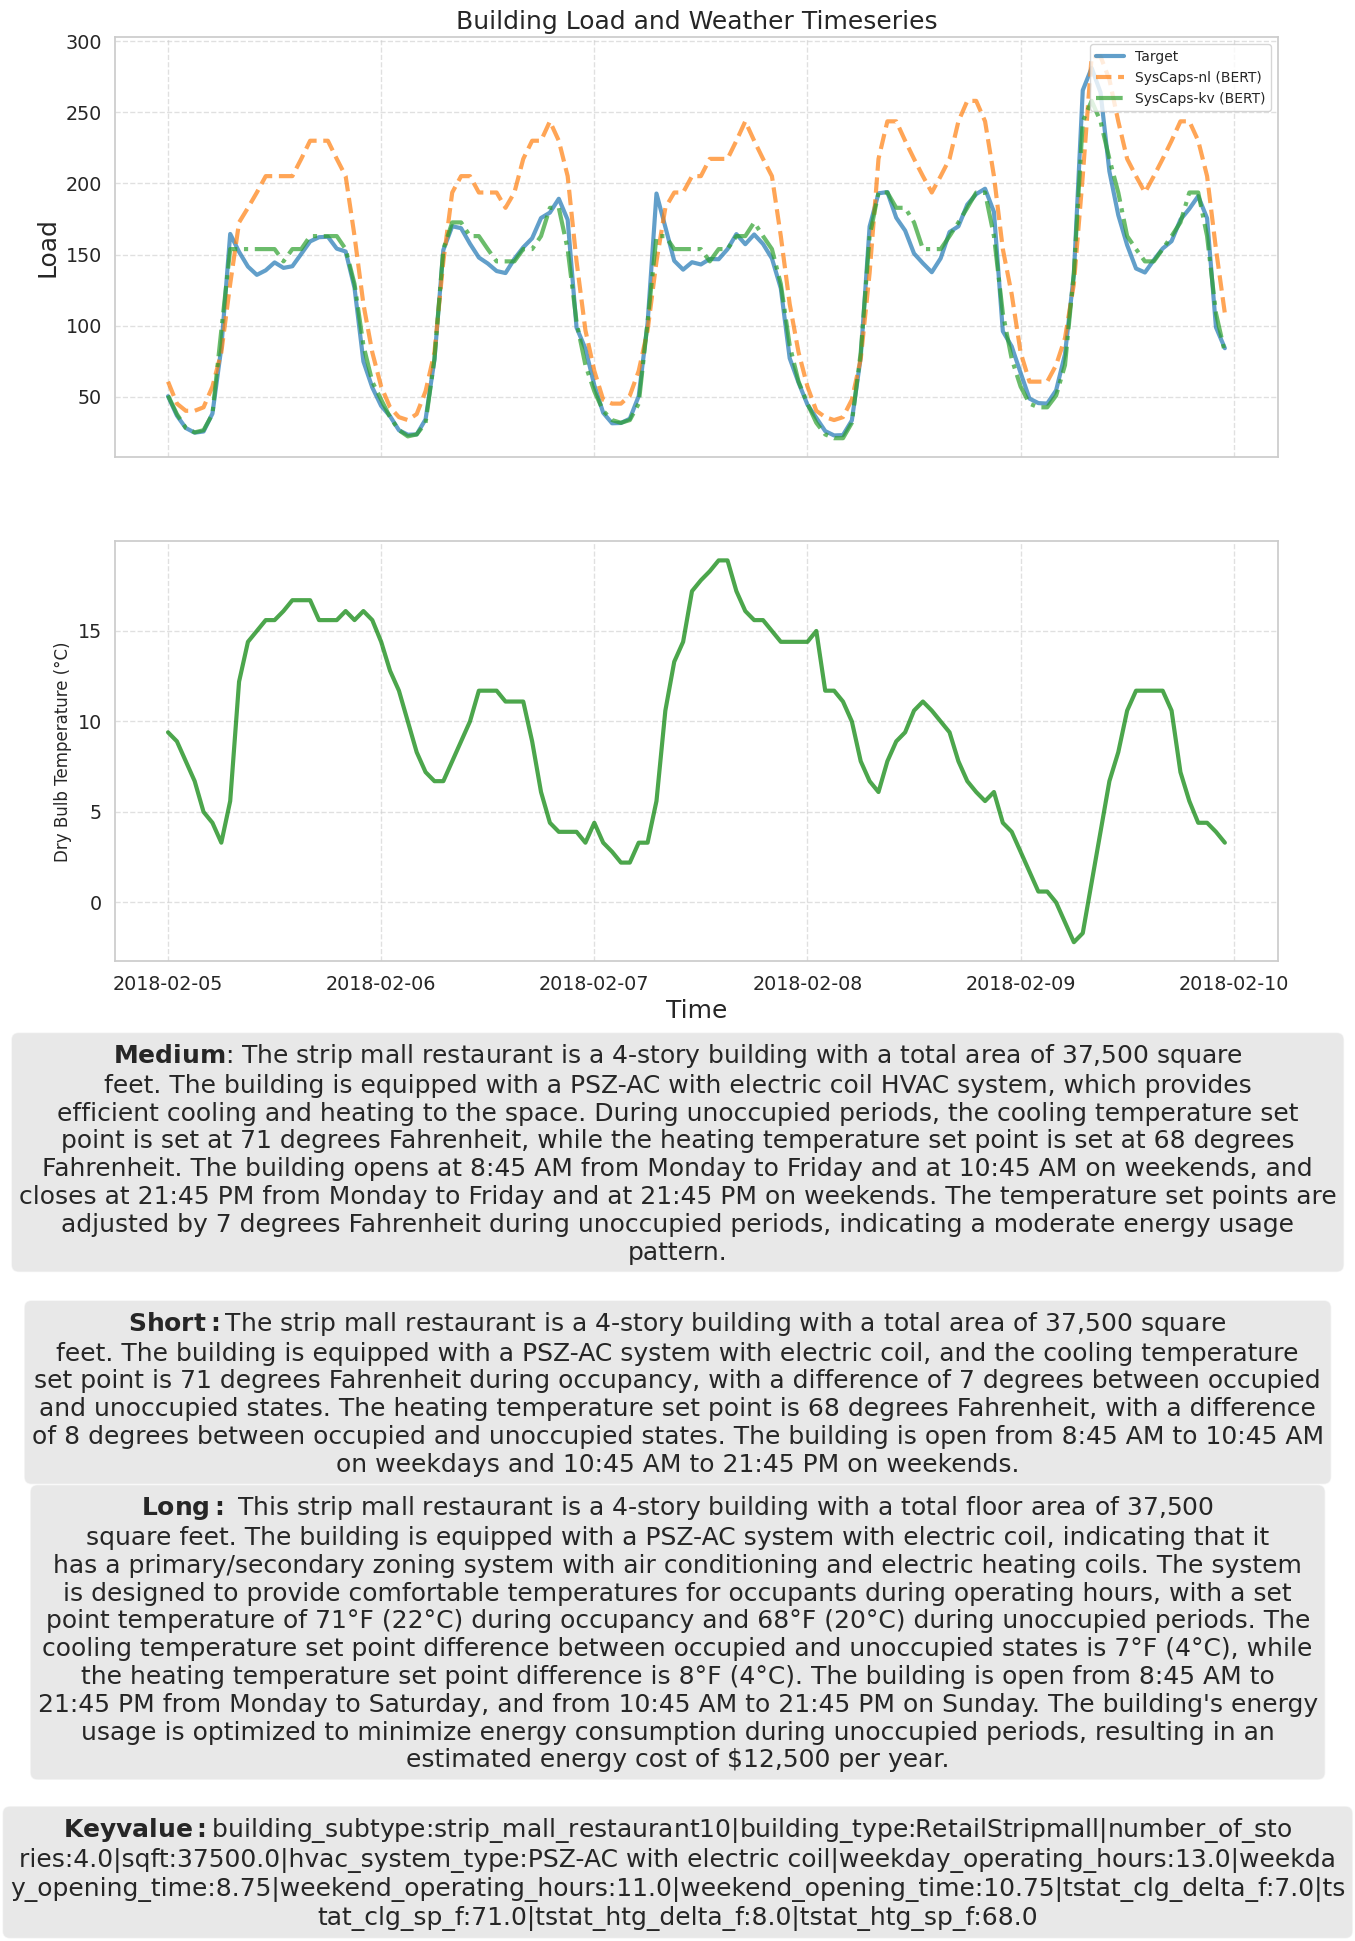

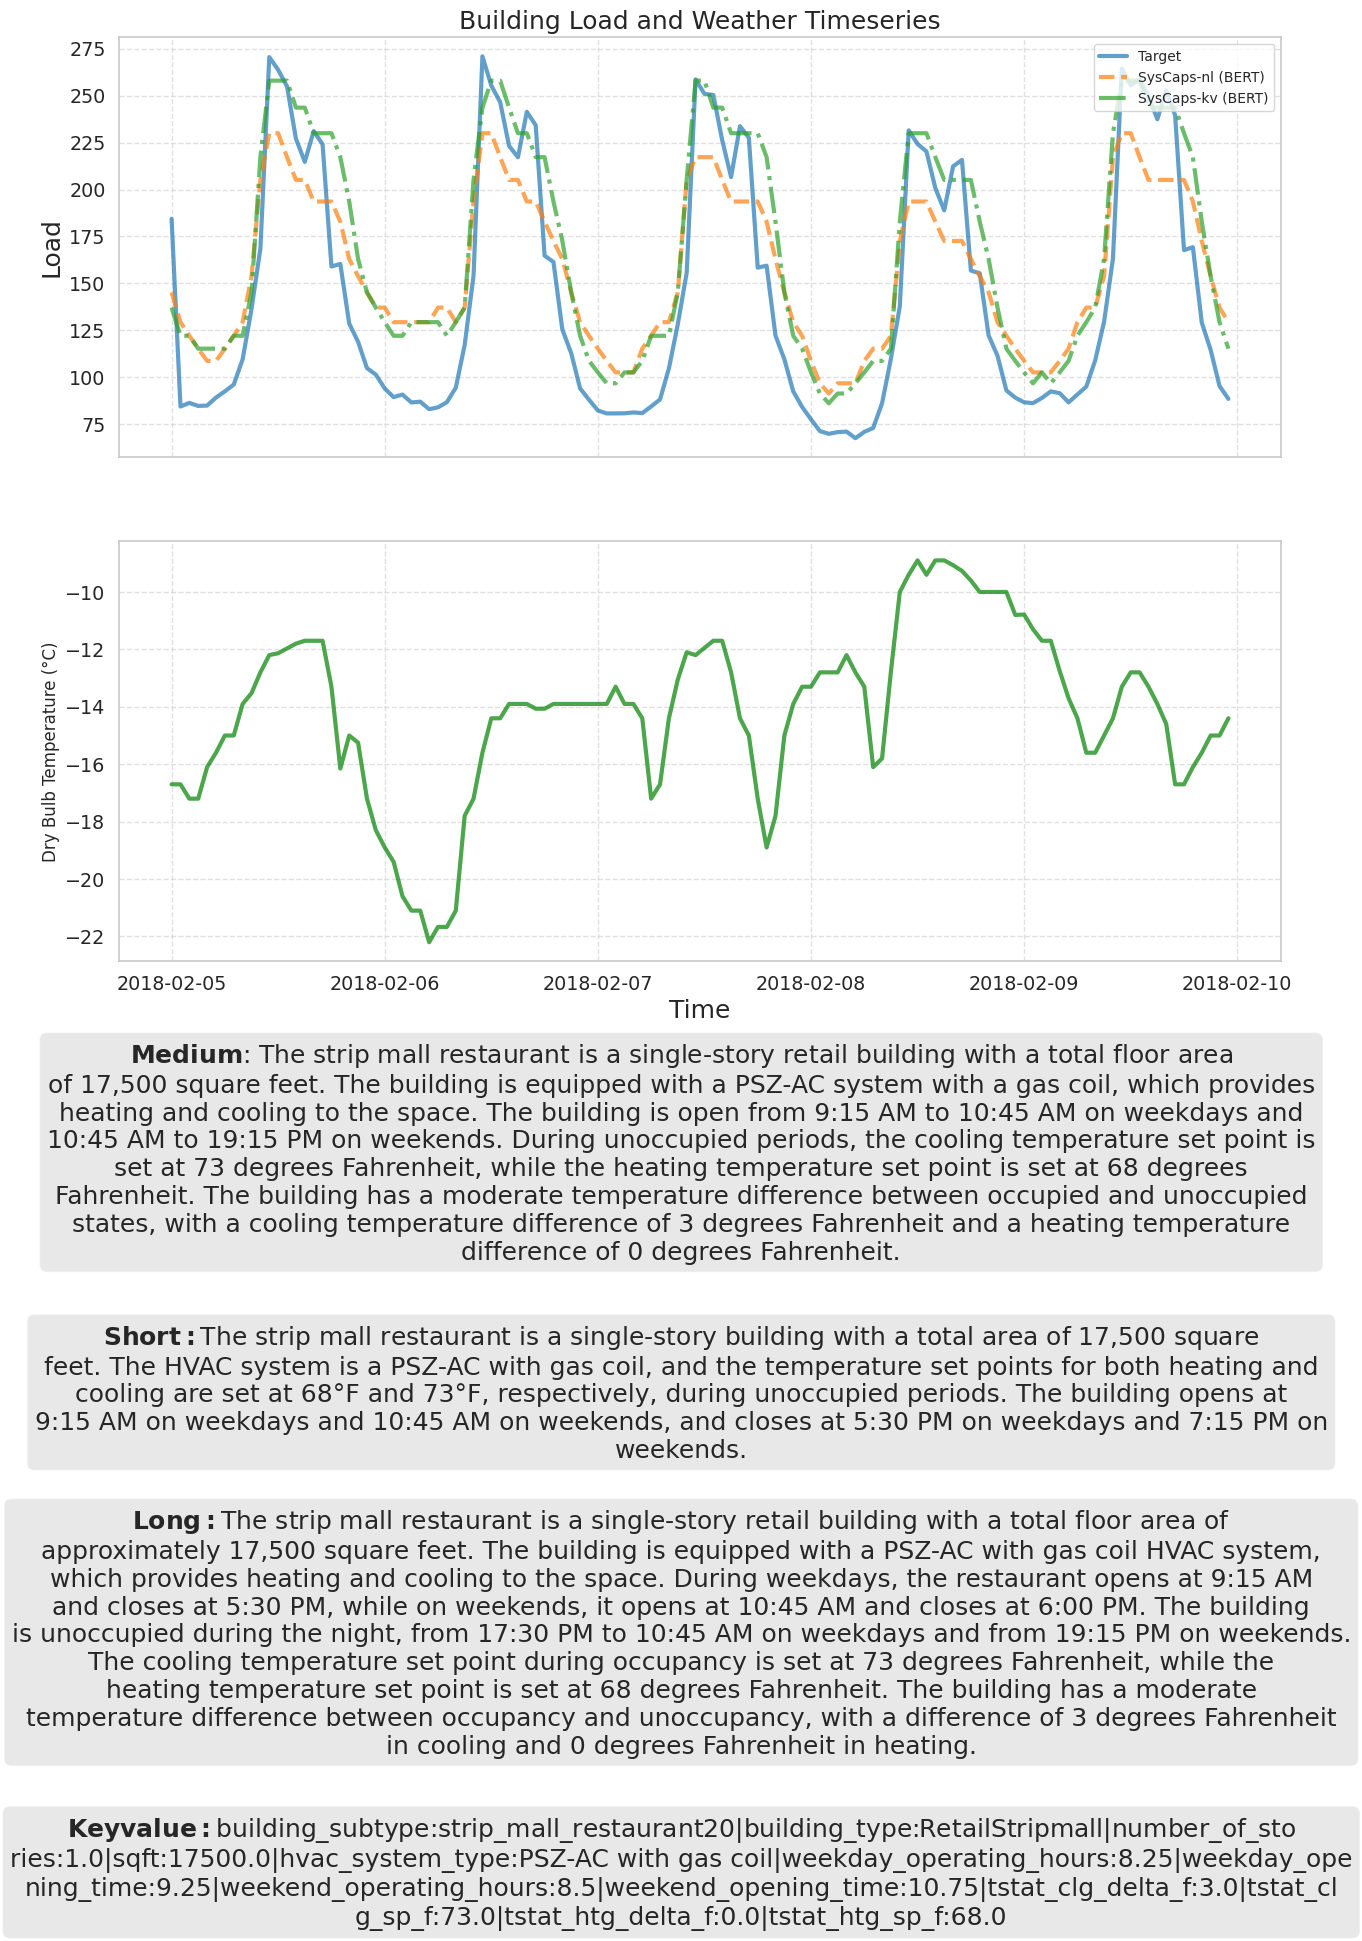

In [44]:
def plot_timeseries_with_syscaps(building, preds, preds_kv, targets, plot_idx, other_captions=None):
    # Extract timestamps
    timestamps = utils.time_features_to_datetime(
        medium_dataset.time_transform.undo_transform(
            torch.cat((building['day_of_year'], building['day_of_week'], building['hour_of_day']), -1)[0].cpu().numpy()
        ), 
        year=2018
    )
    fontsize = 18
    # Extract the week 2018-02-01 to 2018-02-07
    start = 24*7*5
    end = 24*8*5
    wordwrap = 100
    timestamps = timestamps[start:end]
    targets = targets[0][start:end]
    preds = preds[0][start:end]
    preds_kv = preds_kv[0][start:end]
    
    # Create the figure and subplots
    fig, ax = plt.subplots(2, 1, figsize=(15, 12), sharex=True) #, gridspec_kw={'height_ratios': [4, 1]})
    
    # Plot the load timeseries (targets and predictions)
    ax[0].plot(timestamps, targets, label='Target', alpha=0.7, linewidth=3)
    ax[0].plot(timestamps, preds, label='SysCaps-nl (BERT)', alpha=0.7, linewidth=3, linestyle='--')
    ax[0].plot(timestamps, preds_kv, label='SysCaps-kv (BERT)', alpha=0.7, linewidth=3, linestyle='-.')
    
    
    ax[0].set_ylabel('Load', fontsize=fontsize)
    ax[0].set_title('Building Load and Weather Timeseries', fontsize=fontsize)
    ax[0].legend(loc='upper right', fontsize=10, frameon=True)
    ax[0].grid(visible=True, linestyle='--', alpha=0.6)
    # 
    
    # Plot the temperature timeseries
    temps = medium_dataset.weather_transforms[0].undo_transform(building['temperature'].cpu())[0]
    temps = temps[start:end]
    ax[1].plot(timestamps, temps,
               label='Temperature', color='green', alpha=0.7, linewidth=3)
    ax[1].set_ylabel('Dry Bulb Temperature (°C)', fontsize=12)
    ax[1].set_xlabel('Time', fontsize=fontsize)
    
    #ax[1].legend(loc='upper right', fontsize=10, frameon=True)
    ax[1].grid(visible=True, linestyle='--', alpha=0.6)
    
    
    # Add a grid
    plt.grid(visible=True, linestyle='--', alpha=0.6)
    
    # Add labels, title, and legend
    ax[1].set_xlabel('Time', fontsize=fontsize)

    # Format and add syscaps text below the plot
    syscaps = building['syscaps'][0]
    if '\n' in syscaps:
        syscaps = syscaps.split('\n')[1]
    syscaps = r"$\bf{Medium}$" + ': ' + syscaps
    wrapped_syscaps = textwrap.fill(syscaps, width=wordwrap)
    plt.gcf().text(
        0.5, -0.05, wrapped_syscaps, 
        horizontalalignment='center', verticalalignment='center', 
        fontsize=18, bbox=dict(facecolor='lightgrey',
                               alpha=0.5, boxstyle='round,pad=0.3')
    )
    # Add other captions if provided
    if other_captions is not None:
        for idx, (lengt,caption) in enumerate(other_captions):
            if '\n' in caption:
                caption = caption.split('\n')[1]
            caption = lengt + caption
            wrapped_caption = textwrap.fill(caption, width=wordwrap)
            plt.gcf().text(
                0.5, -0.05 - 0.2 * (idx + 1), wrapped_caption, 
                horizontalalignment='center', verticalalignment='center', 
                fontsize=18, bbox=dict(facecolor='lightgrey',
                                       alpha=0.5, boxstyle='round,pad=0.3')
            )
    #plt.tight_layout()
    plt.savefig(f'../results/comstock_qual_{plot_idx}.pdf', bbox_inches='tight')
    plt.savefig(f'../results/comstock_qual_{plot_idx}.png', bbox_inches='tight')
    
    plt.show()

medium_batcher = medium_dataset.collate_fn()
kv_batcher = keyvalue_dataset.collate_fn()
with torch.no_grad():   
    for idx in indices:
        medium_building =  medium_batcher([ medium_dataset[idx] ])
        kv_building = kv_batcher([ keyvalue_dataset[idx] ])
        
        for k,v in medium_building.items():
            if torch.is_tensor(v):
                medium_building[k] = v.to('cuda')         
        with torch.cuda.amp.autocast():
            preds = model.predict(medium_building)
            
        for k,v in kv_building.items():
            if torch.is_tensor(v):
                kv_building[k] = v.to('cuda') 
        with torch.cuda.amp.autocast():
            preds_kv = model_kv.predict(kv_building)
             
        #print(building['syscaps'])
        targets = medium_building['y']
        # unscale loads 
        targets = denorm(targets)
        preds = denorm(preds)
        preds_kv = denorm(preds_kv)
        
        plot_timeseries_with_syscaps(medium_building, preds.cpu(), preds_kv.cpu(), targets.cpu(), idx, other_captions=[
            (r"$\bf{Short:}$",short_dataset[idx]['syscaps']),
            (r"$\bf{Long:}$",long_dataset[idx]['syscaps']),
            (r"$\bf{Keyvalue:}$", keyvalue_dataset[idx]['syscaps'])
        ])
        
        # if idx == 15:
        #     break 


# Wind caption viz

In [46]:
model_config = Path('../syscaps') / 'configs' / 'wind' / 'medium' / 'ResNet.toml'
# grab the custom model args as set in the config file
toml_args = tomli.load((model_config).open('rb'))
# create the model
model = model_factory(toml_args['experiment']['module_name'], 'wind', toml_args['model'])
# load the model weights from HF
#model.from_pretrained('NREL/building-surrogate-nl', use_safetensors=True)
model.load_from_checkpoint('/projects/cascde/pemami/resstock-comstock-surrogates/checkpoints/paper_renamed/resnet_wind_medium_seed=0_merged.pt')
model = model.to('cuda')
# set the model to eval mode
model.eval()

model_kv_config = Path('../syscaps') / 'configs' / 'wind' / 'keyvalue' / 'ResNet.toml'
# grab the custom model args as set in the config file
toml_args = tomli.load((model_config).open('rb'))
# create the model
model_kv = model_factory(toml_args['experiment']['module_name'], 'wind', toml_args['model'])
# load the model weights from HF
#model.from_pretrained('NREL/building-surrogate-nl', use_safetensors=True)
model_kv.load_from_checkpoint('/projects/cascde/pemami/resstock-comstock-surrogates/checkpoints/paper_renamed/resnet_wind_basic_seed=0_merged.pt')
model_kv = model_kv.to('cuda')
# set the model to eval mode
model_kv.eval()

# load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

/projects/cascde/.conda_envs/syscaps/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [47]:
wind_datasets = {}
aug_styles = ['with an objective tone. Creative paraphrasing is acceptable',
                  'with an objective tone',
                  'to a colleague',
                  'to a classroom']
for i in range(4):
    wind_datasets[aug_styles[i]] = WindDataset(
        data_path=Path(SYSCAPS_PATH),
        index_file='floris_test_seed=42.idx',
        syscaps_split='medium',
        use_random_caption_augmentation=False, # turn off augmentation for testing
        caption_augmentation_style=i, # style = with an objective tone
        include_text = True
    )


wind_datasets['keyvalue'] =  WindDataset(
    data_path=Path(SYSCAPS_PATH),
    index_file='floris_test_seed=42.idx',
    syscaps_split='keyvalue',
    use_random_caption_augmentation=False, # turn off augmentation for testing
    caption_augmentation_style=1, # style = with an objective tone
    include_text = True
)

denorm = wind_datasets['with an objective tone'].undo_transform

indices = [1, 10, 20, 30, 50]
# dataloaders = {
#     'medium': torch.utils.data.DataL
# }


OneHotEncoder: # attributes 3, attributes onehot shape = (1, 187)
OneHotEncoder: # attributes 3, attributes onehot shape = (1, 187)


/projects/cascde/.conda_envs/syscaps/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/projects/cascde/.conda_envs/syscaps/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


OneHotEncoder: # attributes 3, attributes onehot shape = (1, 187)
OneHotEncoder: # attributes 3, attributes onehot shape = (1, 187)
OneHotEncoder: # attributes 3, attributes onehot shape = (1, 187)


/projects/cascde/.conda_envs/syscaps/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/projects/cascde/.conda_envs/syscaps/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


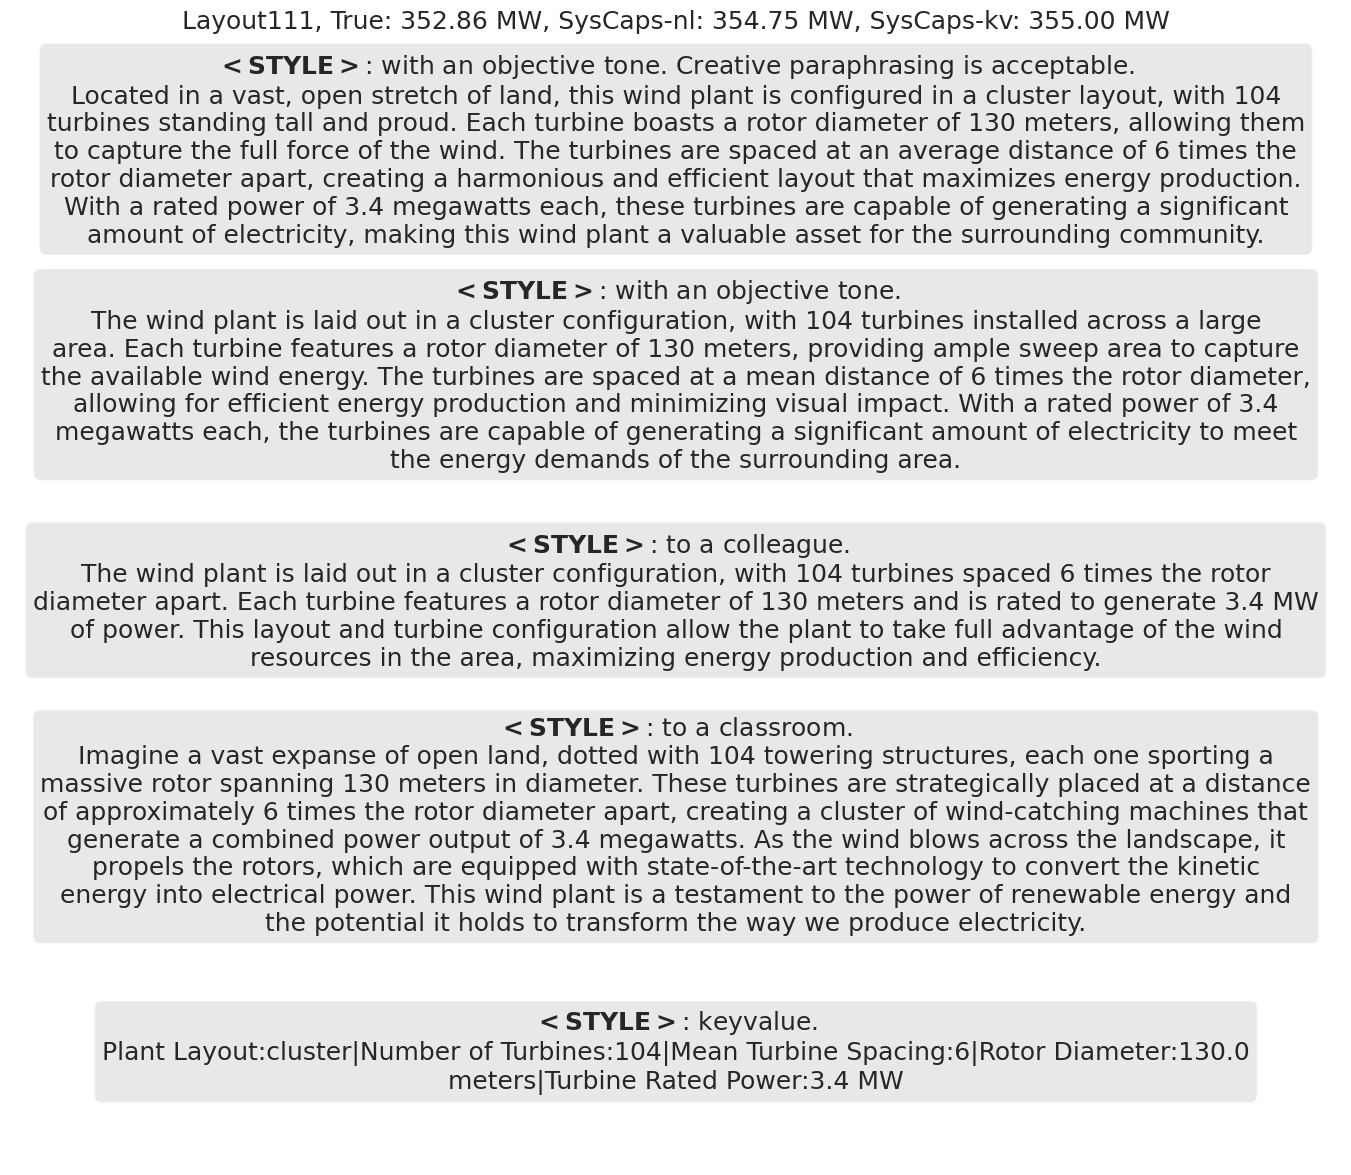

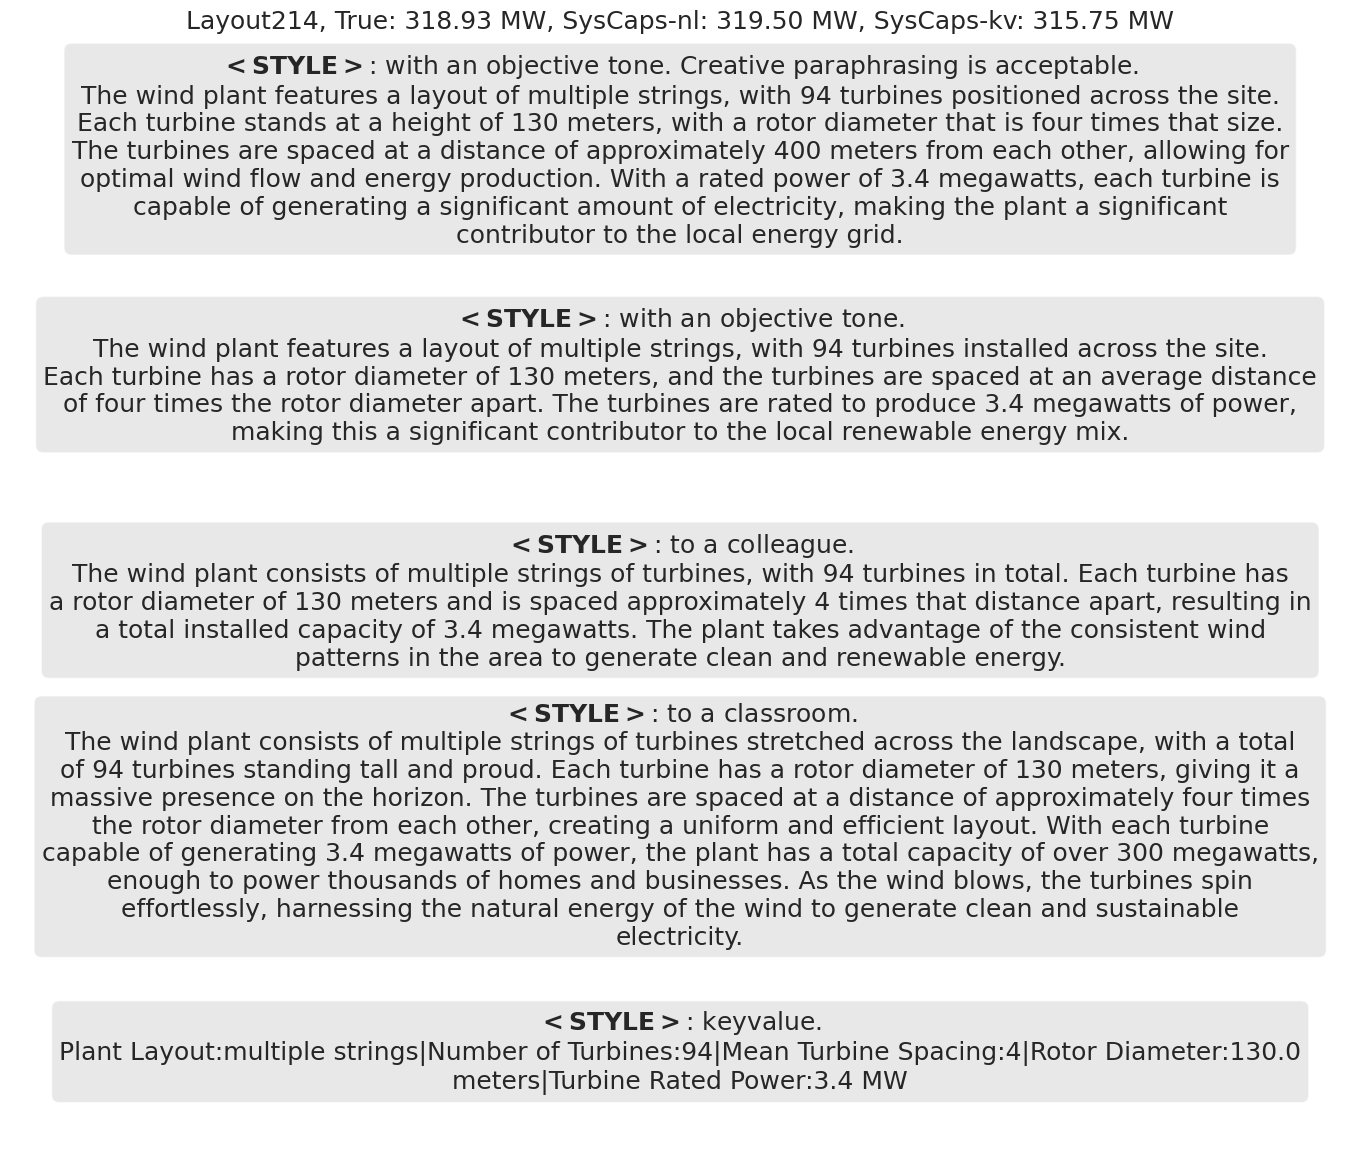

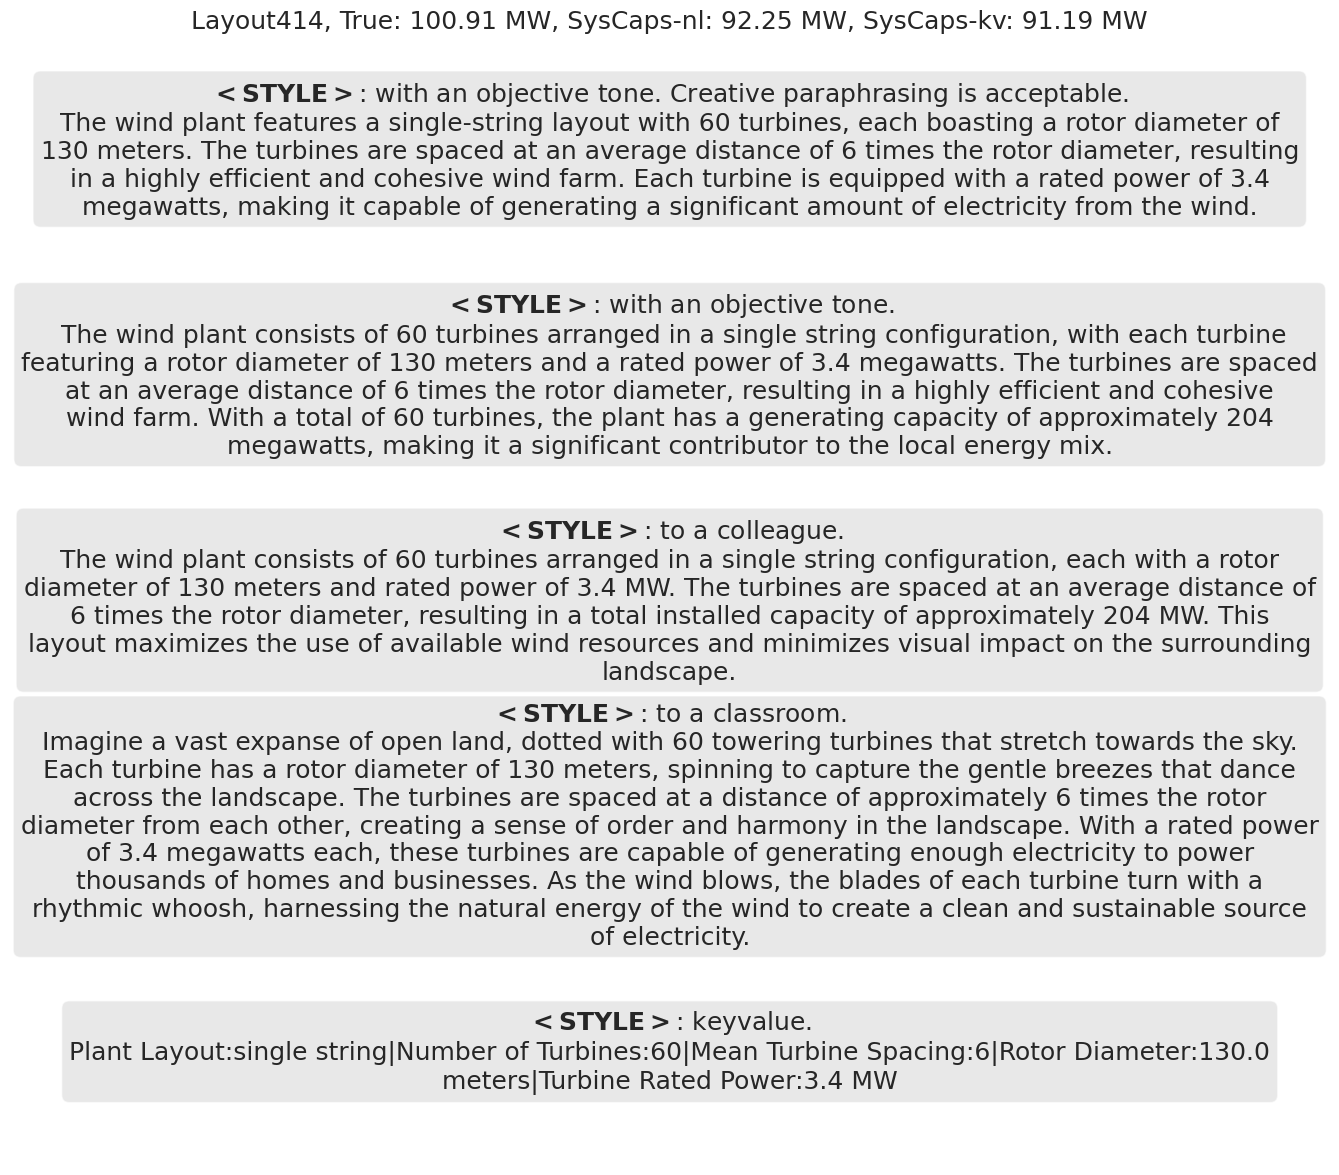

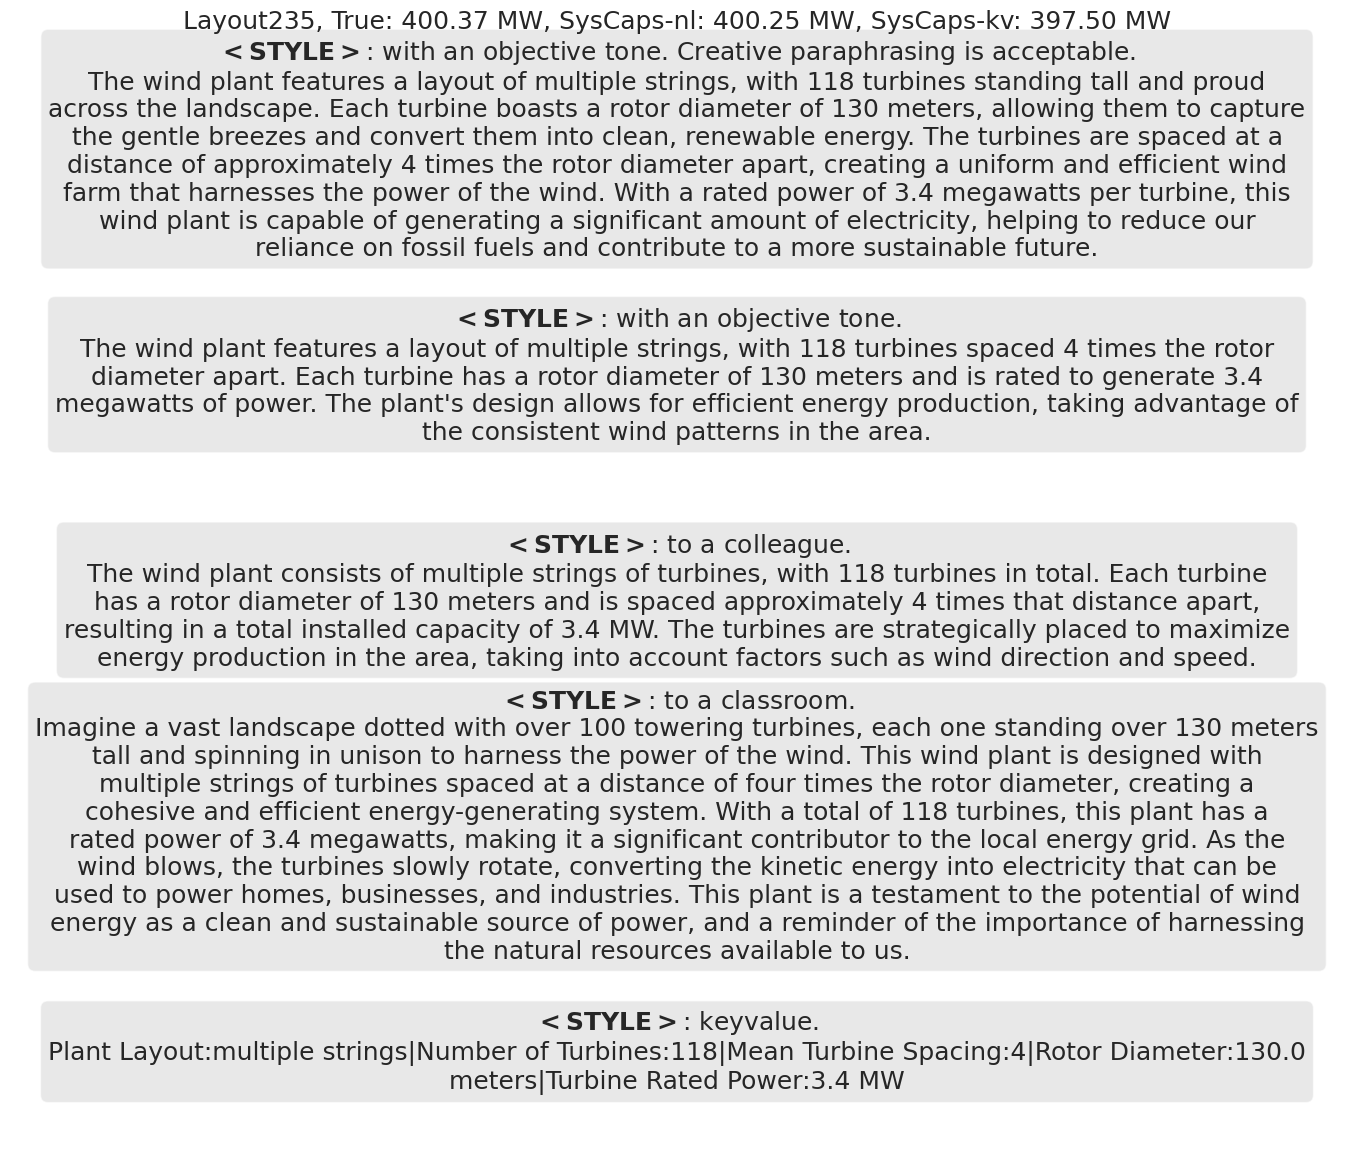

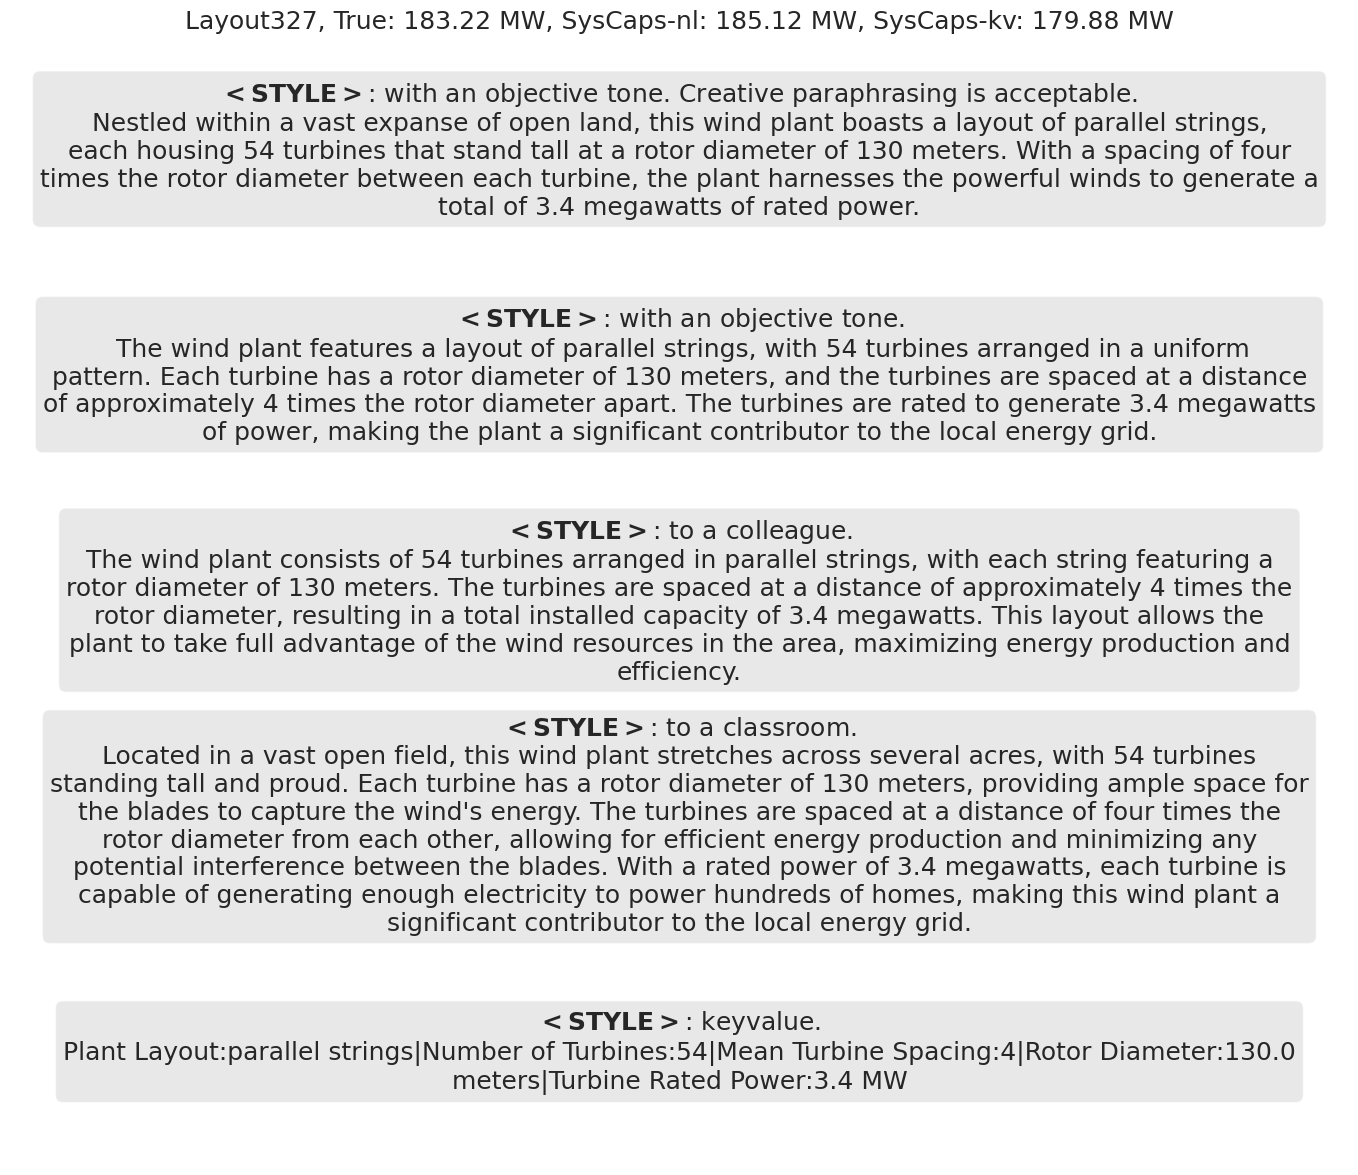

In [52]:
   
# Define vertical spacing
y_positions = [0.9, 0.7, 0.5, 0.3, 0.1]
wordwrap = 100
   
    
with torch.no_grad():   
    for idx in indices:
        
        true = 0
        kv_pred = 0
        nl_pred = 0
 
        fig, ax = plt.subplots(figsize=(15, 12))
        ax.axis('off')  # Turn off the axes
        j = 0
        for dataset_name, dataset in wind_datasets.items(): 
            batcher = dataset.collate_fn()

            wf =  batcher([ dataset[idx] ])
        
            for k,v in wf.items():
                if torch.is_tensor(v):
                    wf[k] = v.to('cuda')         
            with torch.cuda.amp.autocast():
                preds = model.predict(wf)
          
             
            #print(building['syscaps'])
            targets = wf['y']
            # unscale loads 
            targets = denorm(targets).cpu().item()
            preds = denorm(preds)
            if dataset_name == 'keyvalue':
                kv_pred = preds.cpu().item()
            elif dataset_name == 'with an objective tone':
                nl_pred = preds.cpu().item()
                
            syscaps = wf['syscaps'][0]
            if '\n' in syscaps:
                syscaps = syscaps.split('\n')[1]

            if dataset_name != 'keyvalue':
                paragraphs = [ r"$\bf{<STYLE>}$" + f': {dataset_name}',  syscaps ]
            else:
                paragraphs = [ f'{dataset_name}',  syscaps ]
            wrapped_paragraphs = [ textwrap.fill(p, width=wordwrap) for p in paragraphs ]
            text = '\n'.join(wrapped_paragraphs) 
            ax.text(
                0.5, y_positions[j], text,
                ha='center', va='center',
                bbox=dict(facecolor='lightgrey',
                                        alpha=0.5, boxstyle='round,pad=0.3'),
                fontsize=18,
             )
            j += 1
        ax.set_title(f'{wf["layout_id"][0]}' + f', True: {targets:.2f} MW, '
                     f'SysCaps-nl: {nl_pred:.2f} MW, SysCaps-kv: {kv_pred:.2f} MW', fontsize=18)
        
        plt.tight_layout()
        plt.savefig(f'../results/wind_qual_{idx}.pdf' , bbox_inches='tight')
        plt.savefig(f'../results/wind_qual_{idx}.png', bbox_inches='tight')
        # print(medium_wf['syscaps'])
        # print(kv_wf['syscaps'])
        # print(targets)
        # print(preds)
        # print(preds_kv)
        